In [13]:
'''
    Nepali NER for PERSON, ORGANIZATION, LOCATION
    
    Nepali BiLSTM CNN
    
    Author - Oyesh Mann Singh
    Data - 05/03/2019
'''
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(142)

import random
import numpy as np
import pandas as pd

import torchtext
from torchtext import data
from torchtext import vocab
from torchtext import datasets
from torchtext.datasets import SequenceTaggingDataset

from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import conll_eval as e
import sys, unicodedata

from gensim.models import Word2Vec, KeyedVectors
import csv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# txt_field = data.Field(tokenize=list, use_vocab=True, init_token='<init>', eos_token='<eos>')
# label_field = data.Field(unk_token=None, init_token='<init>', eos_token='<eos>')

def split_into_char(x):
    return x.split()

txt_field = data.Field(tokenize=list, use_vocab=True)
pos_field = data.Field(unk_token=None)
label_field = data.Field(unk_token=None)
char_field = data.Field(unk_token='<unk>', sequential=False)
graph_field = data.Field(unk_token='<unk>', sequential=False)

fields = (('TEXT', txt_field),('POS', pos_field),('TAG', label_field))

# root_path='../data/ner/nepaliner/after_stemming/'
root_path='../data/ner/ilprl/'

train_ds, val_ds, test_ds = SequenceTaggingDataset.splits(path=root_path,
                                                 fields=fields,
                                                 separator=' ',
                                                 train='train.txt', validation='val.txt', test='test.txt')

nep2vec = '../data/nep2vec/'
nep2glove='../data/glove'
nep2ft='../data/fasttext/'

# vec = vocab.Vectors(name='nep2vec_clean', cache=nep2vec)
# vec = vocab.Vectors(name='nep2glove-stem.txt', cache=nep2glove)
vec = vocab.Vectors(name='nep2ft.vec', cache=nep2ft)

txt_field.build_vocab(train_ds, test_ds, val_ds, max_size=None, vectors=vec)
label_field.build_vocab(train_ds.TAG, test_ds.TAG, val_ds.TAG)
pos_field.build_vocab(train_ds.POS, test_ds.POS, val_ds.POS)

/home/oyashi/miniconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [14]:
# for i in range(len(txt_field.vocab)):
#     print(txt_field.vocab.itos[i])

print('Length of text vocab = ',len(txt_field.vocab))
print('Length of NER label vocab = ',len(label_field.vocab))
print('Length of POS vocab = ',len(pos_field.vocab))

Length of text vocab =  3254
Length of NER label vocab =  6
Length of POS vocab =  57


In [15]:
# char_list = []
# for each in train_ds.examples + test_ds.examples + val_ds.examples:
#     for x in each.TEXT:
#         char_list+=list(x)
# char_list = list(set(char_list))

# char_list.sort()

# print(char_list)

# char_field.build_vocab(char_list)
# char_vocab_length = len(char_field.vocab)
# print(len(char_field.vocab))
# print(len(char_list))

# with open(root_path+'characters.txt', 'w', encoding='utf-8') as f:
#     for item in char_list:
#         f.write(item+' ')

### Read character level file

In [16]:
with open(root_path+'characters.txt', 'r', encoding='utf-8') as f:
    char_list = f.read().strip().split()
    print(char_list)
    
char_field.build_vocab(char_list)
char_vocab_length = len(char_field.vocab)
print('Length of character vocab = ',len(char_field.vocab))

['"', "'", '(', ')', ',', '-', '.', '/', ':', ';', '?', '[', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो', 'ौ', '्', '।', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '\u200c', '\u200d', '–']
Length of character vocab =  85


In [17]:
# # Create a file full of grapheme cluster and just read those
# from uniseg.graphemecluster import grapheme_clusters
# graph_list = []
# for each in train_ds.examples + test_ds.examples + val_ds.examples:
#     for x in each.TEXT:
#         graph_list+=list(grapheme_clusters(x))
# graph_list = list(set(graph_list))
# graph_list.sort()

# graph_field.build_vocab(graph_list)
# print(len(graph_field.vocab))
# graph_vocab_length = len(graph_field.vocab)
# # for i in range(0, len(graph_field.vocab)):
# #     print(i, graph_field.vocab.itos[i])

# with open(root_path+'grapheme.txt', 'w', encoding='utf-8') as f:
#     for item in graph_list:
#         f.write(item+' ')

### Read grapheme level file

In [18]:
# Create a file full of grapheme cluster and just read those
from uniseg.graphemecluster import grapheme_clusters
with open(root_path+'grapheme.txt', 'r', encoding='utf-8') as f:
    graph_list = f.read().strip().split()
    print(graph_list)
    
graph_list += char_list
graph_list = set(graph_list)
    
graph_field.build_vocab(graph_list)
graph_vocab_length = len(graph_field.vocab)
print('Length of grapheme vocab = ',len(graph_field.vocab))

['"', "'", '(', ')', ',', '-', '.', '/', ':', ';', '?', '[', 'अ', 'अं', 'अ\u200dं', 'आ', 'आँ', 'आं', 'इ', 'इँ', 'ई', 'उ', 'उँ', 'ऊ', 'ऊं', 'ऋ', 'ए', 'एँ', 'ऐ', 'ओ', 'औ', 'क', 'का', 'काँ', 'कां', 'कि', 'की', 'कु', 'कू', 'कृ', 'के', 'कै', 'को', 'कौ', 'क्', 'ख', 'खा', 'खि', 'खी', 'खु', 'खू', 'खे', 'खो', 'खौं', 'ख्', 'ख्\u200d', 'ग', 'गं', 'गा', 'गाँ', 'गि', 'गी', 'गु', 'गृ', 'गे', 'गै', 'गो', 'गौ', 'ग्', 'घ', 'घा', 'घि', 'घी', 'घु', 'घृ', 'घे', 'घो', 'घ्', 'ङ', 'ङ्', 'ङ्\u200d', 'च', 'चँ', 'चा', 'चाँ', 'चां', 'चि', 'ची', 'चु', 'चुँ', 'चू', 'चे', 'चै', 'चो', 'चौ', 'चौं', 'च्', 'छ', 'छा', 'छि', 'छी', 'छु', 'छे', 'छै', 'छो', 'छौ', 'छौं', 'ज', 'जा', 'जाँ', 'जां', 'जि', 'जी', 'जु', 'जू', 'जे', 'जै', 'जो', 'ज्', 'झ', 'झा', 'झि', 'झी', 'झू', 'झे', 'झै', 'झैं', 'झो', 'झों', 'झौ', 'झ्', 'ञ', 'ञा', 'ञे', 'ञ्', 'ञ्\u200d', 'ट', 'टं', 'टा', 'टाँ', 'टि', 'टी', 'टु', 'टे', 'टें', 'टै', 'टो', 'ट्', 'ठ', 'ठा', 'ठि', 'ठी', 'ठू', 'ठे', 'ठो', 'ठ्', 'ड', 'डा', 'डाँ', 'डि', 'डी', 'डु', 'डे', 'डै', 'डो', 'डौ',

In [19]:
# To verify the batch data
def idxtosent(batch, idx):
    '''
        Returns the corresponding TEXT of given batch and index
    '''      
    return ' '.join([txt_field.vocab.itos[i] for i in batch.TEXT[idx].cpu().data.numpy()])


def idxtotag(batch, idx):
    '''
        Returns the corresponding TAG of given batch and index
    '''     
    return ' '.join([label_field.vocab.itos[i] for i in batch.TAG[idx].cpu().data.numpy()])


def tensortosent(tense):
    '''
        Returns the corresponding TEXT of given tensor
    '''     
    return ' '.join([txt_field.vocab.itos[i] for i in tense.cpu().data.numpy()])

def tensortopos(tense):
    '''
        Returns the corresponding TEXT of given tensor
    '''     
    return ' '.join([pos_field.vocab.itos[i] for i in tense.cpu().data.numpy()])

def tensortotag(tense):
    '''
        Returns the corresponding TEXT of given tensor
    '''     
    return ' '.join([label_field.vocab.itos[i] for i in tense.cpu().data.numpy()])

def tensorToOneHot(tense):
    '''
        Returns the corresponding TEXT of given tensor
    '''
    try:
        return pos_one_hot[tense.cpu().data.numpy()]
    except ValueError:
        return pos_one_host[-1]


def NumpyToSent(tensor):
    '''
        Returns the corresponding TEXT of given Predictions
        Returns chunks of string
    '''    
    return ' '.join([txt_field.vocab.itos[i[0]] for i in tensor.cpu().data.numpy()]).split()


def PredToTag(predictions):
    '''
        Returns the corresponding TAGS of given Predictions
        Returns chunks of string
    '''
    return ' '.join([label_field.vocab.itos[i] for i in predictions]).split()

# Because len(pos) = 56 and len(pos_field.vocab) = 55
n_values=len(pos_field.vocab)+2
pos_one_hot = np.eye(n_values)
one_hot_weight = torch.from_numpy(pos_one_hot).float()

class BatchGenerator:
    def __init__(self, dl, x_field, y_field, z_field):
        self.dl, self.x_field, self.y_field, self.z_field = dl, x_field, y_field, z_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            z = getattr(batch, self.z_field)
            yield ((X,y), z)

def plot_loss(train_loss, val_loss, title):
    plt.figure(figsize=[8,5])
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()
    
def save_checkpoint(model, opt, train_loss, train_acc, val_loss, val_acc, filename, epochs):
    save_parameters = {'model': model,
                       'state_dict':model.state_dict(),
                       'opt':opt,
                       'opt_state': opt.state_dict(),
                      'train_loss' : train_loss,
                      'train_acc' : train_acc,
                      'val_loss' : val_loss,
                      'val_acc' : val_acc,
                      'epochs' : epochs}
    torch.save(save_parameters, filename)
    
    
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    opt = checkpoint['opt']
    opt.load_state_dict(checkpoint['opt_state'])
    train_loss = checkpoint['train_loss']
    train_acc = checkpoint['train_acc']
    val_loss = checkpoint['val_loss']
    val_acc = checkpoint['val_acc']
    epochs = checkpoint['epochs']
    
    return model, opt, train_loss, train_acc, val_loss, val_acc, epochs

def fit(model, train_dl, val_dl, loss_fn, opt, start_epoch, lstm_model_file, epochs=1):
    total_train_loss = []
    total_train_acc = []
    total_val_loss = []
    total_val_acc = []
    num_batch = len(train_dl)
    prev_lstm_val_acc=0.0
    prev_val_loss=100.0
    counter=0
    patience_limit=10
    for epoch in tnrange(start_epoch, epochs):      
        z_true_train = list()
        z_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for ((X,y),z) in t:
            t.set_description(f'Epoch {epoch+1}')
            
            opt.zero_grad()
            pred = model(X, y)
            
            z = z.reshape(z.shape[0]*z.shape[1])
            loss = loss_fn(pred, z)
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]

            
            z_true_train += list(z.cpu().data.numpy())
            z_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()

        train_acc = accuracy_score(z_true_train, z_pred_train)
        train_loss = total_loss_train/len(train_dl)
        total_train_loss.append(train_loss)
        total_train_acc.append(train_acc)
        
        if val_dl:
            z_true_val = list()
            z_pred_val = list()
            total_loss_val = 0
            for ((X,y),z) in tqdm_notebook(iter(val_dl), leave=False):
                pred = model(X, y)
                z = z.reshape(z.shape[0]*z.shape[1])
                loss = loss_fn(pred, z)
                pred_idx = torch.max(pred, 1)[1]
                z_true_val += list(z.cpu().data.numpy())
                z_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
                
            valacc = accuracy_score(z_true_val, z_pred_val)
            valloss = total_loss_val/len(val_dl)
            print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')
        total_val_loss.append(valloss)
        total_val_acc.append(valacc)
        
        if valloss < prev_val_loss:
            save_checkpoint(model, opt, 
                            total_train_loss,
                            total_train_acc,
                            total_val_loss,
                            total_val_acc, 
                            lstm_model_file,
                            epoch)
            prev_val_loss = valloss
            counter=0
            print("This model saved!!!")
        else: 
            counter += 1
            
        if counter >= patience_limit: 
            print("Training stopped because maximum tolerance reached!!!")
            break
            
    return model, opt, total_train_loss, total_train_acc, total_val_loss, total_val_acc

In [28]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, char_dim, batch_size, vocab_size, 
                 tagset_size, weights, one_hot_weight, bidirection=False, num_layers=1,
                char_level=False, pos_level=False, graph_level=False):
        super(LSTMTagger, self).__init__()
        self.bidirectional = bidirection
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.char_embed_num = char_vocab_length
        self.graph_embed_num = graph_vocab_length
        self.char_dim = char_dim
        self.word_embeddings = nn.Embedding.from_pretrained(weights)
        self.one_hot_embeddings = nn.Embedding(n_values, n_values, _weight=one_hot_weight)
        self.char_embeddings = nn.Embedding(self.char_embed_num, self.char_dim, padding_idx=0)
        self.graph_embeddings = nn.Embedding(self.graph_embed_num, self.char_dim, padding_idx=0)
        self.char_level=char_level
        self.pos_level=pos_level
        self.graph_level=graph_level
        
        nn.init.xavier_uniform_(self.char_embeddings.weight)
        nn.init.xavier_uniform_(self.graph_embeddings.weight)
        
        self.rnn = nn.RNN(embedding_dim, self.hidden_dim, 
                            bidirectional=self.bidirectional, 
                            num_layers=self.num_layers)         
        
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, 
                            bidirectional=self.bidirectional, 
                            num_layers=self.num_layers)
        if self.bidirectional:
            self.hidden2tag = nn.Linear(self.hidden_dim * 2, tagset_size)
        else:
            self.hidden2tag = nn.Linear(self.hidden_dim * 2, tagset_size)      
        self.dropout = nn.Dropout(0.5)
        self.dropout_embed = nn.Dropout(0.5)
        
        self.linear1=nn.Linear(self.embedding_dim, self.hidden_dim)
        self.linear2=nn.Linear(self.hidden_dim, tagset_size)
        
        #------------CNN
        # Changed here for padding_idx error
        self.conv_filter_sizes=[3,4,5]
        self.conv_filter_nums=self.char_dim       # 30
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = self.conv_filter_nums, 
                                              kernel_size = (fs, self.char_dim)) 
                                    for fs in self.conv_filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(self.conv_filter_sizes) * self.conv_filter_nums, self.char_dim)

    def init_hidden(self, tensor_size):
        if self.bidirectional:
            h0 = torch.zeros(2 * self.num_layers, tensor_size[1], self.hidden_dim)
            c0 = torch.zeros(2 * self.num_layers, tensor_size[1], self.hidden_dim)         
        else:
            h0 = torch.zeros(self.num_layers, tensor_size[1], self.hidden_dim)
            c0 = torch.zeros(self.num_layers, tensor_size[1], self.hidden_dim)         
        if device:
            h0 = h0.to(device)
            c0 = c0.to(device)
        return (h0, c0)
    
    def get_char_tensor(self, X):
        words=[]
        for i in range(0, len(X)):
            character=[]
            char_int=[]
            chunk = []
            bigger_chunk = []
            # For character-level
            if self.char_level:
                character+="".join(str(x) for x in tensortosent(X[i]))
                char_int+=(char_field.vocab.stoi[c] for c in character)
            # For grapheme-level
            else:
                character+=[str(x) for x in grapheme_clusters(tensortosent(X[i]))]
                char_int+=(graph_field.vocab.stoi[c] for c in character)
            words.append(char_int)

        # Get the max length of the words in a sentence
        length = max(map(len, words))

        # Padding to match the max_length words whose size is less than max(filter_size)
        if length < max(self.conv_filter_sizes):
            length += max(self.conv_filter_sizes) - length

        # Zero-padding the unequal sentences
        X_char=np.array([xi+[0]*(length-len(xi)) for xi in words])
        X_char=torch.from_numpy(X_char)
        
        return X_char    
    
    
    # ---------------------------------------CHARACTER FORWARD
    def _char_forward(self, inputs):
        """
        Args:
            inputs: 3D tensor, [bs, max_len]
        Returns:
            char_conv_outputs: 3D tensor, [bs, max_len, output_dim]
        """
        max_len = inputs.size(1)
        inputs=inputs.to(device)
        if self.char_level:
            input_embed = self.char_embeddings(inputs)  # [bs, ml, feature_dim]
        else:
            input_embed=self.graph_embeddings(inputs)

        # Since convolution is 2-dimension, we need 4 dimension tensor
        input_embed = input_embed.unsqueeze(1)         # [bs, 1, max_len, feature_dim]
                                                                 
        # conv
        conved = [F.relu(conv(input_embed)).squeeze(3) for conv in self.convs]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        return self.fc(cat)
    
    
    def forward(self, X, y):
#         print("Shape of X", X.shape)
        if self.char_level or self.graph_level:
            # Get the X_char for each item in a batch here
            # And concatenate in the end
            # or do it insied get_char_tensor(X)
            X_char=self.get_char_tensor(X)
#             print("Shape of X_char", X_char.shape)
            
        X = self.word_embeddings(X)
        X = self.dropout_embed(X)

        # Do the convolution here
        if (self.char_level or self.graph_level):
            char_conv = self._char_forward(X_char)
            char_conv = char_conv.unsqueeze(1)
#             print("Shape of char_conv", char_conv.shape)            
            X=torch.cat((X,char_conv), dim=-1)
        
        # Concatenate POS-embedding here
        if self.pos_level:
            POS = self.one_hot_embeddings(y)
            X=torch.cat((X,POS), dim=-1)
            
        self.hidden = self.init_hidden(list(X.size()))
        '''
        This dropout was after LSTM layer, need to run experiment
        and check result what happens, if it is kept before LSTM
        All other researcher, have generally kept it before LSTM
        '''
        X = self.dropout(X)          
        self.lstm.flatten_parameters()
#         print("Shape of X before lstm", X.shape)            
        X, _ = self.lstm(X, self.hidden)  
#         print("Shape of X after lstm", X.shape)            
#         self.rnn.flatten_parameters()   
#         X, _ = self.rnn(X, self.hidden[0]) 

        X = torch.tanh(X)
        tag_space = self.hidden2tag(X.view(-1, X.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


ONLY CHAR or GRAPHEME USED!!!!!!!!


Epoch 1: train_loss: 0.3981 train_acc: 0.9142 | val_loss: 0.3058 val_acc: 0.9090
This model saved!!!


/home/oyashi/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTMTagger. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/oyashi/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/oyashi/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/oyashi/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch 2: train_loss: 0.2328 train_acc: 0.9304 | val_loss: 0.2310 val_acc: 0.9200
This model saved!!!


Epoch 3: train_loss: 0.1709 train_acc: 0.9351 | val_loss: 0.1803 val_acc: 0.9392
This model saved!!!



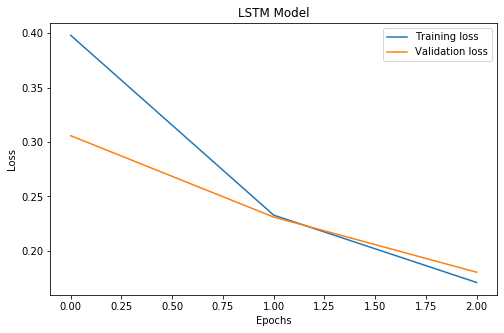

In [30]:
vocab_size = len(txt_field.vocab)
CHAR_DIM = 30
pos_level=False
char_level=True
graph_level=False
EMBEDDING_DIM = vec.dim

if (pos_level and (char_level or graph_level)):
    assert(char_level != graph_level),"Only one variable can be True at a time"
    print("POS AND CHAR/GRAPHEME BOTH USED!!!!!!!!")
    EMBEDDING_DIM += n_values + CHAR_DIM
elif (char_level or graph_level):
    assert(char_level != graph_level),"Only one variable can be True at a time"
    print("ONLY CHAR or GRAPHEME USED!!!!!!!!")
    EMBEDDING_DIM += CHAR_DIM
elif pos_level:
    print("ONLY POS USED!!!!!!!!")
    EMBEDDING_DIM += n_values
else:
    print("NORMAL EMBEDDING USED!!!!!!!!")

HIDDEN_DIM=100
tagset_size = len(label_field.vocab)
batch_size=1
weights = txt_field.vocab.vectors

lstm_model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, CHAR_DIM, batch_size=batch_size,
                        vocab_size=vocab_size, tagset_size=tagset_size,
                        weights=weights,one_hot_weight=one_hot_weight,
                        bidirection=True, num_layers=1, char_level=char_level,
                       pos_level=pos_level, graph_level=graph_level).to(device)

loss_func = nn.NLLLoss()

opt = optim.Adam(filter(lambda p: p.requires_grad, lstm_model.parameters()), lr=0.001, weight_decay=0.000001)

num_of_epochs=3

train_iter, val_iter = data.BucketIterator.splits(datasets=(train_ds, val_ds), 
                                            batch_sizes=(batch_size, batch_size), 
                                            sort_key=lambda x: len(x.TEXT), 
                                            device=device, 
                                            sort_within_batch=True, 
                                            repeat=False,
                                            shuffle=True)

train_batch_it = BatchGenerator(train_iter, 'TEXT', 'POS', 'TAG')
val_batch_it = BatchGenerator(val_iter, 'TEXT', 'POS', 'TAG')

model_name='lstm'

lstm_model_file = '../data/models/' + model_name + '.pth'

if os.path.exists(lstm_model_file):
    os.remove(lstm_model_file)

if os.path.exists(lstm_model_file):
    lstm_model, opt, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc, epoch = load_checkpoint(lstm_model_file)

    print(f'Epoch {epoch}: train_loss: {lstm_train_loss[-1]:.4f} train_acc: {lstm_train_acc[-1]:.4f} | val_loss: {lstm_val_loss[-1]:.4f} val_acc: {lstm_val_acc[-1]:.4f}')
    # Resume training (Need to fix it)
    if num_of_epochs > epoch:
        lstm_model, opt, tmp_train_loss, tmp_train_acc, tmp_val_loss, tmp_val_acc = fit(model=lstm_model,
                                                                                       train_dl=train_batch_it, 
                                                                                       val_dl=val_batch_it, 
                                                                                       loss_fn=loss_func, 
                                                                                       opt=opt,
                                                                                       start_epoch=epoch,
                                                                                       epochs=num_of_epochs)
        lstm_train_loss += tmp_train_loss
        lstm_train_acc += tmp_train_acc
        lstm_val_loss += tmp_val_loss
        lstm_val_acc += tmp_val_acc
        
        save_checkpoint(lstm_model, opt, 
                        lstm_train_loss,
                        lstm_train_acc,
                        lstm_val_loss,
                        lstm_val_acc,
                        lstm_model_file, 
                        num_of_epochs)

else:
    lstm_model, opt, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = fit(model=lstm_model,
                                                                                        train_dl=train_batch_it,
                                                                                        val_dl=val_batch_it,
                                                                                        loss_fn=loss_func,
                                                                                        opt=opt,
                                                                                        start_epoch=0,
                                                                                        lstm_model_file=lstm_model_file,
                                                                                        epochs=num_of_epochs)
#     save_checkpoint(lstm_model, opt, 
#                 lstm_train_loss,
#                 lstm_train_acc,
#                 lstm_val_loss,
#                 lstm_val_acc,
#                 lstm_model_file, 
#                 num_of_epochs)

plot_loss(lstm_train_loss, lstm_val_loss, title='LSTM Model')

## Evaluation phase

In [11]:
def write_results(model, dataset, train_file, test_file, val_file):

    train_iter, test_iter, val_iter = data.BucketIterator.splits(datasets=dataset, 
                                                batch_sizes=(1, 1, 1), 
                                                sort_key=lambda x: len(x.TEXT), 
                                                device=device, 
                                                sort_within_batch=True, 
                                                repeat=False,
                                                shuffle=False)

    train_batch_it = BatchGenerator(train_iter, 'TEXT', 'POS', 'TAG')
    test_batch_it = BatchGenerator(test_iter, 'TEXT', 'POS', 'TAG')
    val_batch_it = BatchGenerator(val_iter, 'TEXT', 'POS', 'TAG')

    with open(train_file, 'w', encoding='utf-8') as rtrn:
        model.eval()
        print('Writing in file: ',train_file)
        for ((X,y),z) in iter(train_batch_it):
            sent = NumpyToSent(X)
            pred = model(X,y)
            pred_idx = torch.max(pred, 1)[1]

            z = z.view(-1)
            z_true_val = z.cpu().data.numpy().tolist()
            true_tag = PredToTag(z_true_val)

            z_pred_val = pred_idx.cpu().data.numpy().tolist()
            pred_tag = PredToTag(z_pred_val)

            for s, gt, pt in zip(sent, true_tag, pred_tag):
                rtrn.write(s+' '+gt+' '+pt+'\n')
            rtrn.write('\n')
    rtrn.close()
    
    with open(test_file, 'w', encoding='utf-8') as rtst:
        model.eval()
        print('Writing in file: ',test_file)
        for ((X,y),z) in iter(test_batch_it):
            sent = NumpyToSent(X)
            pred = model(X,y)
            pred_idx = torch.max(pred, 1)[1]

            z = z.view(-1)
            z_true_val = z.cpu().data.numpy().tolist()
            true_tag = PredToTag(z_true_val)

            z_pred_val = pred_idx.cpu().data.numpy().tolist()
            pred_tag = PredToTag(z_pred_val)

            for s, gt, pt in zip(sent, true_tag, pred_tag):
                rtst.write(s+' '+gt+' '+pt+'\n')
            rtst.write('\n')
    rtst.close()
    
    with open(val_file, 'w', encoding='utf-8') as rval:
        model.eval()
        print('Writing in file: ',val_file)
        for ((X,y),z) in iter(val_batch_it):
            sent = NumpyToSent(X)
            pred = model(X,y)
            pred_idx = torch.max(pred, 1)[1]

            z = z.view(-1)
            z_true_val = z.cpu().data.numpy().tolist()
            true_tag = PredToTag(z_true_val)

            z_pred_val = pred_idx.cpu().data.numpy().tolist()
            pred_tag = PredToTag(z_pred_val)

            for s, gt, pt in zip(sent, true_tag, pred_tag):
                rval.write(s+' '+gt+' '+pt+'\n')
            rval.write('\n')
    rval.close()    

file_train=model_name +'_train.txt'
file_test=model_name +'_test.txt'
file_val=model_name +'_val.txt'

result_train = '../data/ner/results/' + file_train
result_test = '../data/ner/results/' + file_test
result_val = '../data/ner/results/' + file_val

load_best_model=True
if load_best_model:
    print("Loading best model!!!")
    lstm_model, opt, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc, epoch = load_checkpoint(lstm_model_file)

write_results(model=lstm_model, dataset=(train_ds, test_ds, val_ds), 
              train_file=result_train,
              test_file=result_test, 
              val_file=result_val)

Loading best model!!!
Writing in file:  ../data/ner/results/lstm_train.txt
Writing in file:  ../data/ner/results/lstm_test.txt
Writing in file:  ../data/ner/results/lstm_val.txt


In [12]:
"""
    These are NOT actual CONLL evaluation
    You need to run separately
"""
e.evaluate_conll_file(result_train)

processed 9014 tokens with 471 phrases; found: 489 phrases; correct: 432.
accuracy:  96.37%; (non-O)
accuracy:  99.13%; precision:  88.34%; recall:  91.72%; FB1:  90.00
              LOC: precision:  93.02%; recall:  96.77%; FB1:  94.86  129
             MISC: precision:  86.54%; recall:  94.74%; FB1:  90.45  208
              ORG: precision:  74.51%; recall:  79.17%; FB1:  76.77  51
              PER: precision:  93.07%; recall:  86.24%; FB1:  89.52  101


(96.36608344549126, 88.34355828220859, 91.71974522292994, 90.0)

In [13]:
e.evaluate_conll_file(result_test)

processed 3116 tokens with 143 phrases; found: 144 phrases; correct: 106.
accuracy:  79.53%; (non-O)
accuracy:  97.75%; precision:  73.61%; recall:  74.13%; FB1:  73.87
              LOC: precision:  82.46%; recall:  75.81%; FB1:  78.99  57
             MISC: precision:  70.00%; recall:  85.71%; FB1:  77.06  60
              ORG: precision:  50.00%; recall:  60.00%; FB1:  54.55  6
              PER: precision:  66.67%; recall:  51.85%; FB1:  58.33  21


(79.53488372093024, 73.61111111111111, 74.12587412587412, 73.86759581881532)

In [14]:
e.evaluate_conll_file(result_val)

processed 2279 tokens with 132 phrases; found: 138 phrases; correct: 101.
accuracy:  79.73%; (non-O)
accuracy:  97.19%; precision:  73.19%; recall:  76.52%; FB1:  74.81
              LOC: precision:  72.50%; recall:  82.86%; FB1:  77.33  40
             MISC: precision:  85.96%; recall:  89.09%; FB1:  87.50  57
              ORG: precision:  16.67%; recall:  18.18%; FB1:  17.39  12
              PER: precision:  72.41%; recall:  67.74%; FB1:  70.00  29


(79.72972972972973, 73.18840579710145, 76.51515151515152, 74.81481481481481)

In [ ]:
import os
print('Completed everything')
os._exit(0)

In [ ]:
def get_truth_pred(fileName):
    true_seqs, pred_seqs = [], []
    
    with open(fileName, 'r', encoding='utf-8') as f:
        for line in f:
            cols = line.strip().split()
            # each non-empty line must contain >= 3 columns
            if not cols:
                true_seqs.append('O')
                pred_seqs.append('O')
            elif len(cols) < 3:
                raise IOError("conlleval: too few columns in line %s\n" % line)
            else:
                # extract tags from last 2 columns
                true_seqs.append(cols[-2])
                pred_seqs.append(cols[-1])
    return true_seqs, pred_seqs

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def display_confusion_matrix(filename, title):
    y_true, y_pred = get_truth_pred(filename)
    labels=["B-PER", "B-LOC", "B-ORG", "B-MISC", "I-PER", "I-LOC", "I-ORG", "I-MISC", "O", "<pad>"]
    labels=["PER", "LOC", "ORG", "MISC", "O", "<pad>"]
    
#     tag_dict = {"B-PER": 0, "B-LOC": 1, "B-ORG": 2, "B-MISC" : 3, "I-PER": 4, "I-LOC": 5, "I-ORG": 6, "I-MISC":7, "O": 8, '<pad>':9}
    tag_dict = {"PER": 0, "LOC": 1, "ORG": 2, "MISC" : 3, "O": 4, '<pad>':5}

    y_true_final = list(map(tag_dict.get, y_true))
    y_pred_final = list(map(tag_dict.get, y_pred))

    plot_confusion_matrix(y_true_final, y_pred_final, classes=labels, normalize=False, title=title)

In [ ]:
display_confusion_matrix(result_train, 'Confusion matrix on train data')

In [ ]:
display_confusion_matrix(result_test, 'Confusion matrix on test data')

In [ ]:
display_confusion_matrix(result_val, 'Confusion matrix on val data')

In [ ]:
pd.options.display.max_rows = 999
'''
    Get the TP/FP/FN based on PER/ORG/LOC TAG only
'''
def get_stats(src_file, dest_file):
    df = pd.read_csv(src_file, delimiter=' ', encoding='utf-8', skip_blank_lines=True, quoting=csv.QUOTE_NONE, header=None, names=['TEXT', 'GT', 'PT'])
    entity_df = df[(df.PT == 'ORG') | (df.PT == 'PER') | (df.PT == 'LOC') | (df.GT == 'ORG') | (df.GT == 'PER') | (df.GT == 'LOC') | (df.GT == 'MISC') | (df.PT == 'MISC')].reset_index(drop=True)
    
    num_of_words = len(entity_df)

    acc_df = entity_df[entity_df.GT == entity_df.PT].reset_index(drop=True)

    org_tp = acc_df[acc_df.GT == 'ORG'].reset_index(drop=True)
    org_tp['COMMENTS']='ORG_TP'
    per_tp = acc_df[acc_df.GT == 'PER'].reset_index(drop=True)
    per_tp['COMMENTS']='PER_TP'
    loc_tp = acc_df[acc_df.GT == 'LOC'].reset_index(drop=True)
    loc_tp['COMMENTS']='LOC_TP'
    misc_tp = acc_df[acc_df.GT == 'MISC'].reset_index(drop=True)
    misc_tp['COMMENTS']='MISC_TP'

    org_fn = entity_df[(entity_df.GT == 'ORG') & (entity_df.PT != 'ORG')].reset_index(drop=True)
    org_fn['COMMENTS']='ORG_FN'
    per_fn = entity_df[(entity_df.GT == 'PER') & (entity_df.PT != 'PER')].reset_index(drop=True)
    per_fn['COMMENTS']='PER_FN'
    loc_fn = entity_df[(entity_df.GT == 'LOC') & (entity_df.PT != 'LOC')].reset_index(drop=True)
    loc_fn['COMMENTS']='LOC_FN'
    misc_fn = entity_df[(entity_df.GT == 'MISC') & (entity_df.PT != 'MISC')].reset_index(drop=True)
    misc_fn['COMMENTS']='MISC_FN'    

    org_fp = entity_df[(entity_df.PT == 'ORG') & (entity_df.GT != 'ORG')].reset_index(drop=True)
    org_fp['COMMENTS']='ORG_FP'
    per_fp = entity_df[(entity_df.PT == 'PER') & (entity_df.GT != 'PER')].reset_index(drop=True)
    per_fp['COMMENTS']='PER_FP'
    loc_fp = entity_df[(entity_df.PT == 'LOC') & (entity_df.GT != 'LOC')].reset_index(drop=True)
    loc_fp['COMMENTS']='LOC_FP'
    misc_fp = entity_df[(entity_df.PT == 'MISC') & (entity_df.GT != 'MISC')].reset_index(drop=True)
    misc_fp['COMMENTS']='MISC_FP'    
    
    final_df=pd.concat([org_tp, per_tp, loc_tp, misc_tp, org_fn, per_fn, loc_fn, misc_fn, org_fp, per_fp, loc_fp, misc_fp], ignore_index=True)
    final_df.to_csv(dest_file, sep='\t',encoding='utf-8',index=False,header=True)
    return final_df

file=file_train
root='../data/ner/results/'
source_file = root+file
dest_file=root+'stat_'+file
result_df=get_stats(source_file, dest_file)

In [ ]:
result_df[(result_df.COMMENTS=='LOC_FN')]

In [ ]:
count_df=result_df[result_df.COMMENTS=='ORG_FN']

list_text=list(count_df.TEXT.values)

import collections
counter=collections.Counter(list_text)
print(counter)